# Datasets for robot imitation learning

A class containing processing code for all the datasets needed for the robot imitation learning project, as well as debugging code. The class here is the development version, the active version is in Datasets.py

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython import display
import pickle
import logging
import platform
import time
%matplotlib inline

from CVAE_VisualModule import CVAE_VisualModule
import paths

# logging.getLogger().setLevel(logging.DEBUG)

In [6]:
class Datasets:
                
    @staticmethod
    def create_unsupervised_dataset(image_dir, batch = 16, img_height = 32, img_width = 32, do_resize = False):
        """Create a dataset for training an autoencoder (unsupervised data) from all the image files in the top level of
        the image_dir directory.
        The image files are loaded first in the memory, resized and put in an array. Then we create the dataset from those
        tensor slices.
        FIXME: this might be somewhat expensive, and one needs to keep it in the memory
        """
        logging.info(f"Started creating unsupervised dataset from {image_dir}")
        pic_list = []
        count = 0
        for image_filename in pathlib.Path(image_dir).iterdir():
            # print(image_filename)
            img = tf.io.read_file(str(image_filename))
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.convert_image_dtype(img, tf.float32)
            if do_resize:
                img = tf.image.resize(img, [img_width, img_height])
            pic_list.append(img)
            count = count + 1
            if count % 5000 == 0:
                logging.info(f"At image: {count}")

        logging.info("About to create dataset from tensor slices")
        dataset = tf.data.Dataset.from_tensor_slices(pic_list)
        logging.info("About to shuffle")
        dataset = dataset.shuffle(1000) # buffer size 1000
        logging.info("About to batch")
        dataset = dataset.batch(batch, drop_remainder = True)
        logging.info(f"Done creating unsupervised dataset from {image_dir} with {count} images")
        return dataset

    @staticmethod
    def create_image_control_demonstration_dataset(control_path, pictures_dir, maxcnt=999):
        """Creates a demonstration dataset of (image, control) pairs. 
        The input is the format chosen by Rouhollah. For the given task, at the top of the directory there is a
        text cvs file with the columns:

        time,task,user,robot,reward,gripper,joint1,joint2,joint3,joint4,joint5,joint6

        There is a picture directory where there is a collection of jpg pictures 0.jpg... 

        There is one-to-one mapping between the lines in the text file and the pictures. 
        The dataset generated is created as 2 columns "image" and "control". 
        The control is only the gripper and joint values. 
        """
        # Load the file and read it line by line
        logging.info(f"Started creating image control demonstration dataset from {control_path}")
        f = control_path.open()
        controls = []
        images = []
        for line, text in enumerate(f):
            if line < 3:
                continue
            count = line - 3
            if count == maxcnt:
                break
            control = np.fromstring(text, sep=",")
            # get the gripper value and the 6 joint values
            control = control[4:11]
            # print(control)
            image_filename = pathlib.Path(pictures_dir, f"{count}.jpg")
            if image_filename.exists():
                img = tf.io.read_file(str(image_filename))
                img = tf.image.decode_jpeg(img, channels=3)
                img = tf.image.convert_image_dtype(img, tf.float32)
                count = count + 1
            else:
                raise Exception(f"Could not find image {image_filename}")
                # logging.warning(f"Could not find image {image_filename} - skipping")
                continue
            # create the pairs
            controls.append(control)
            images.append(img)
            if line % 5000 == 0:
                logging.info(f"At line: {line}")
        df_tensor = {"image" : images, "control": controls}
        dataset = tf.data.Dataset.from_tensor_slices(df_tensor)
        logging.info(f"Done creating image control demonstration dataset, total size {len(controls)}")
        return dataset

## Dataset inspection functions

In [7]:
def inspect_demonstration_dataset(ds, from_image, to_image, wait_time = 1):
    """Inspect some points in a demonstration dataset by printing the image and the controls"""
    for i, element in enumerate(ds):
        if i < from_image:
            continue
        if i > to_image:
            break
        print(f"Control and image at timestep {i}")
        print(list(element['control'].numpy()))
        plt.imshow(element['image'], extent=[0, 32, 0, 32])
        display.display(plt.gcf())
        #display.clear_output(wait=False)
        display.clear_output(wait=True)
        time.sleep(wait_time)

In [8]:
def inspect_unsupervised_dataset(ds, from_image, to_image, wait_time = 1):
    """Inspect some points in an unsupervised dataset. Here probably we to go by batch"""
    count = 0
    for element in ds:
        batchsize = len(element)
        for i in range(0, batchsize):
            if count+i < from_image:
                continue
            if count+i > to_image:
                break
            print(f"Image number timestep {i}")
            plt.imshow(element[i], extent=[0, 32, 0, 32])
            display.display(plt.gcf())
            #display.clear_output(wait=False)
            display.clear_output(wait=True)
            time.sleep(wait_time)
        count = count + batchsize
        if count > to_image:
            break

## Validate whether we are reading in the right way the unsupervised datasets

In [9]:
ds = Datasets.create_unsupervised_dataset(paths.unsupervised_dir)

INFO:root:Started creating unsupervised dataset from /home/lboloni/Documents/HackingWork/2021-05-01-RobotImitationLearning/data/images-32-task-3001-10090
INFO:root:About to create dataset from tensor slices
INFO:root:About to shuffle
INFO:root:About to batch
INFO:root:Done creating unsupervised dataset from /home/lboloni/Documents/HackingWork/2021-05-01-RobotImitationLearning/data/images-32-task-3001-10090 with 111 images


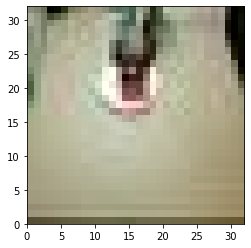

In [62]:
element = inspect_unsupervised_dataset(ds, 0, 10)

In [67]:
pictures_dir = pathlib.Path(paths.demonstrations_rouhi_dir, "task-3001", "10090", "camera-1")
ds = Datasets.create_unsupervised_dataset(pictures_dir)

INFO:root:At image: 5000
INFO:root:At image: 10000
INFO:root:At image: 15000
INFO:root:At image: 20000
INFO:root:At image: 25000
INFO:root:At image: 30000
INFO:root:At image: 35000
INFO:root:At image: 40000
INFO:root:At image: 45000
INFO:root:At image: 50000
INFO:root:At image: 55000


## Validate whether we are reading in the right way the demonstrations

In [36]:
# the small demonstration data that had been packaged with the source
control_path = pathlib.Path(paths.demonstration_dir, "10090.txt")
pictures_dir = pathlib.Path(paths.demonstration_dir, "pictures")

ds = Datasets.create_image_control_demonstration_dataset(control_path, pictures_dir, maxcnt=-1)

INFO:root:Started creating image control demonstration dataset from /home/lboloni/Documents/HackingWork/2021-05-01-RobotImitationLearning/data/demonstration-32-task-3001-10090/10090.txt
INFO:root:Done creating image control demonstration dataset, total size 1000


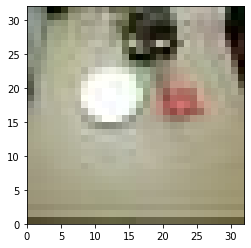

In [37]:
inspect_demonstration_dataset(ds, 1, 5, 5)

In [32]:
# an example demonstration data from Rouhollah's code 
control_path = pathlib.Path(paths.demonstrations_rouhi_dir, "task-3001", "10090.txt")
pictures_dir = pathlib.Path(paths.demonstrations_rouhi_dir, "task-3001", "10090", "camera-1")
ds = Datasets.create_image_control_demonstration_dataset(control_path, pictures_dir, maxcnt=-1)

INFO:root:Started creating image control demonstration dataset from /home/lboloni/Documents/HackingWork/2021-05-01-Rouhollah-Code-and-Data/trajectories/al5d-32/task-3001/10090.txt
INFO:root:At line: 5000
INFO:root:At line: 10000
INFO:root:At line: 15000
INFO:root:At line: 20000
INFO:root:At line: 25000
INFO:root:At line: 30000
INFO:root:At line: 35000
INFO:root:At line: 40000
INFO:root:At line: 45000
INFO:root:At line: 50000
INFO:root:At line: 55000
INFO:root:Done creating image control demonstration dataset, total size 55163
